In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the data
df = pd.read_csv('~/Desktop/datacamp/merged_inputed_data.csv')

## Reduce features down to first 30 days of clinical data

In [2]:
# create list with column names that start with 'meds' and ends with _0, _1, _2, _3, _4
meds = [col for col in df.columns if col.startswith('meds') and col.endswith(('_0', '_1', '_2', '_3', '_4'))]

tests = [col for col in df.columns if col.startswith('test') and col.endswith(('_0', '_1', '_2', '_3', '_4'))]

surveys = [col for col in df.columns if col.startswith('survey') and col.endswith(('_0', '_4'))]

data = df[meds+tests+surveys+['responder']]

data

,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,...,survey_propoxyphene_0,survey_cannabis_4,survey_oxycodone_4,survey_methadone_4,survey_amphetamine_4,survey_methamphetamine_4,survey_opiates_4,survey_benzodiazepines_4,survey_propoxyphene_4,responder
0,0.0,8.0,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1
1,0.0,8.0,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0
2,30.0,0.0,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0
3,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,0.0,2.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0
4,0.0,16.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,30.0,0.0,270.0,0.0,390.0,0.0,560.0,0.0,420.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,1
1301,0.0,8.0,0.0,32.0,0.0,64.0,0.0,80.0,0.0,96.0,...,0.0,27.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0
1302,30.0,0.0,690.0,0.0,1460.0,0.0,100.0,0.0,1400.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1303,110.0,0.0,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Train the model

In [3]:
import shap
from sklearn.model_selection import train_test_split

X, y = data.drop('responder', axis=1), data['responder']    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# define categorical and numerical features
cats = ['test_Propoxyphene_0', 'test_Amphetamines_0', 'test_alcohol_0', 'test_Cannabinoids_0','test_Benzodiazepines_0', 'test_Methadone_0', 'test_Oxycodone_0', 'test_Cocaine_0', 'test_Methamphetamine_0',
 'test_Opiate300_0', 'test_Propoxyphene_1', 'test_Amphetamines_1', 'test_alcohol_1', 'test_Cannabinoids_1','test_Benzodiazepines_1', 'test_Methadone_1', 'test_Oxycodone_1', 'test_Cocaine_1', 'test_Methamphetamine_1',
 'test_Opiate300_1', 'test_Propoxyphene_2', 'test_Amphetamines_2', 'test_alcohol_2', 'test_Cannabinoids_2',
 'test_Benzodiazepines_2', 'test_Methadone_2', 'test_Oxycodone_2', 'test_Cocaine_2', 'test_Methamphetamine_2',
 'test_Opiate300_2', 'test_Propoxyphene_3', 'test_Amphetamines_3', 'test_alcohol_3', 'test_Cannabinoids_3',
 'test_Benzodiazepines_3', 'test_Methadone_3', 'test_Oxycodone_3', 'test_Cocaine_3', 'test_Methamphetamine_3',
 'test_Opiate300_3', 'test_Propoxyphene_4', 'test_Amphetamines_4', 'test_alcohol_4', 'test_Cannabinoids_4',
 'test_Benzodiazepines_4', 'test_Methadone_4', 'test_Oxycodone_4', 'test_Cocaine_4', 'test_Methamphetamine_4',
 'test_Opiate300_4']

nums = ['meds_methadone_0', 'meds_buprenorphine_0', 'meds_methadone_1','meds_buprenorphine_1', 'meds_methadone_2',
 'meds_buprenorphine_2', 'meds_methadone_3', 'meds_buprenorphine_3', 'meds_methadone_4', 'meds_buprenorphine_4','survey_cannabis_0', 'survey_oxycodone_0', 'survey_methadone_0', 'survey_amphetamine_0', 'survey_methamphetamine_0',
 'survey_opiates_0', 'survey_benzodiazepines_0', 'survey_propoxyphene_0', 'survey_cannabis_4', 'survey_oxycodone_4',
 'survey_methadone_4', 'survey_amphetamine_4', 'survey_methamphetamine_4', 'survey_opiates_4',
'survey_benzodiazepines_4', 'survey_propoxyphene_4',]

# define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nums)
        ])

# define pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=123))
    ])

# fit the pipeline to the training data
model.fit(X_train, y_train)

# calculate the accuracy on the test set
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.7318007662835249


In [6]:
X_sub = shap.sample(X_train, 200)
ex = shap.Explainer(model.predict_proba, X_sub)
shap_values = ex(X_test.iloc[0:200])

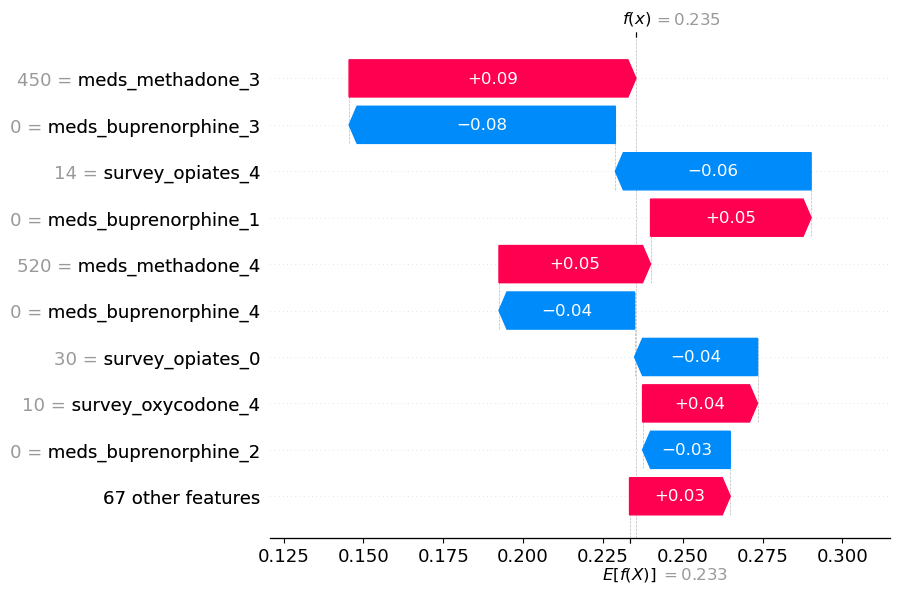

In [7]:
class_index = 1
data_index = 1
shap.plots.waterfall(shap_values[data_index,:,class_index])

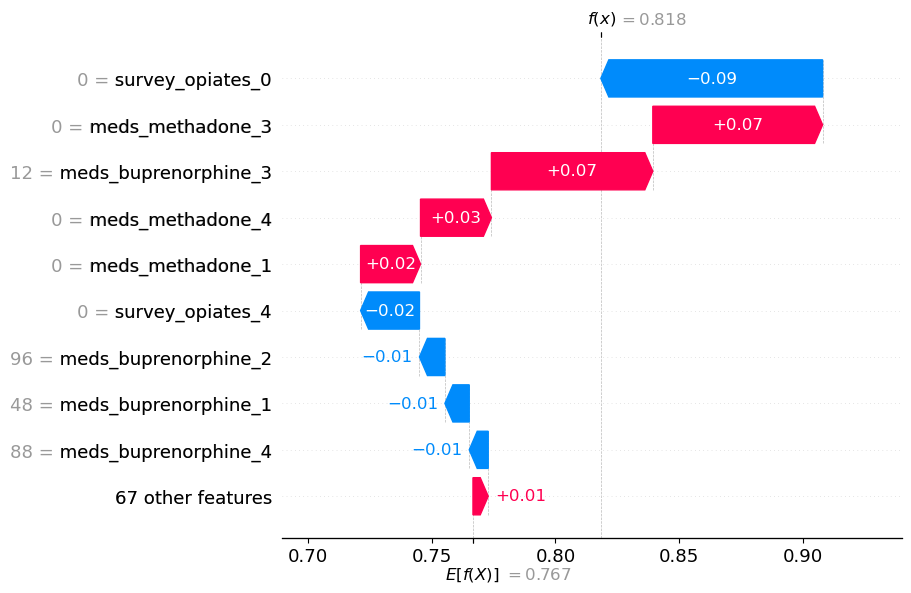

In [8]:
class_index = 0
data_index = 98
shap.plots.waterfall(shap_values[data_index,:,class_index])

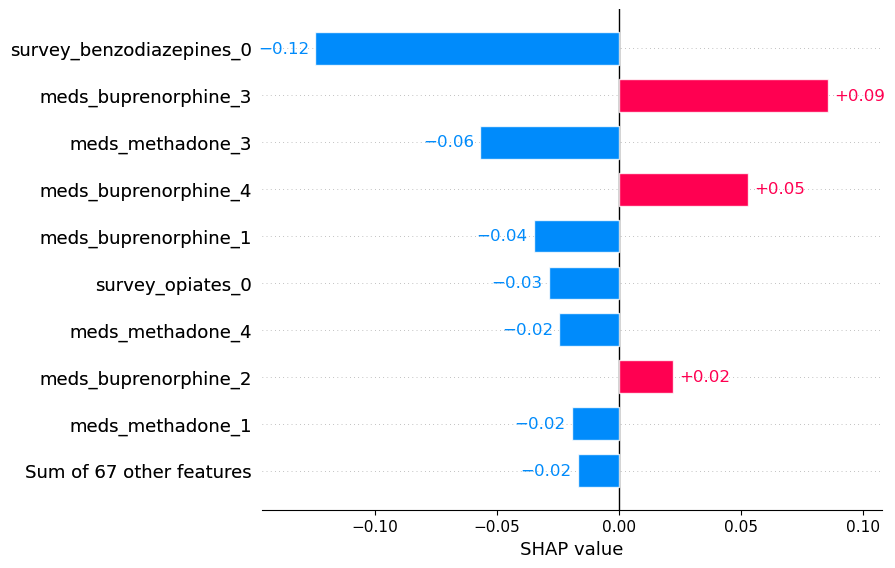

In [9]:
class_index = 1
data_index = 5
shap.plots.bar(shap_values[data_index,:,class_index])

data_index: [128]


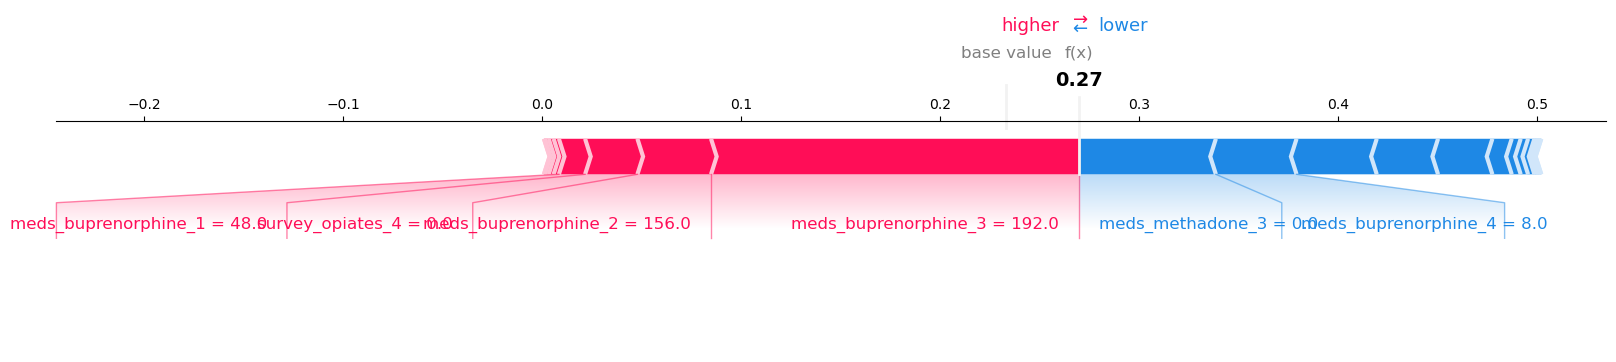

In [14]:
class_index = 1
data_index = np.random.choice(X_sub.shape[0], 1, replace=False)
print('data_index:', data_index )

shap.initjs()
shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True)

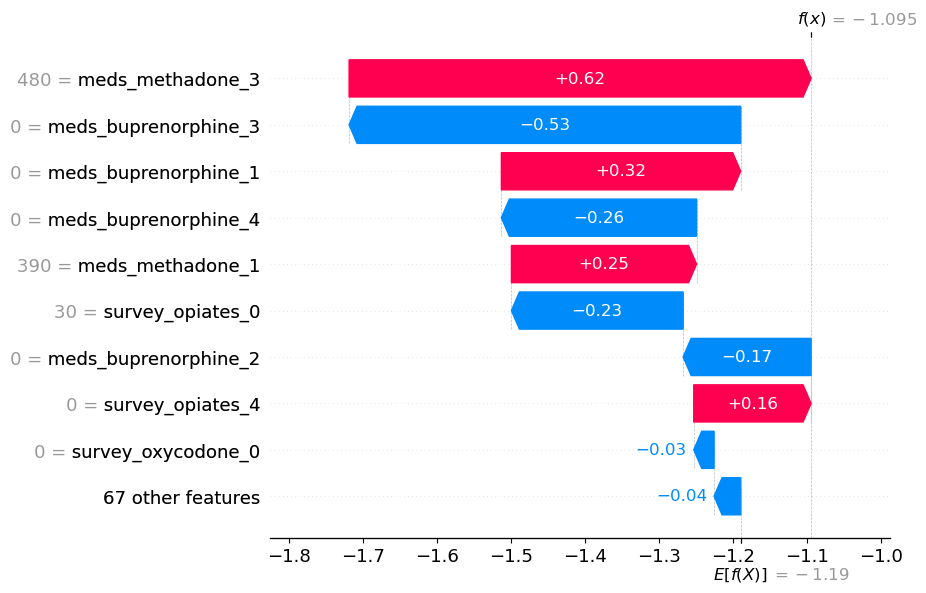

In [15]:
data_index = 2
class_index = 1

ex_logit = shap.Explainer(
model.predict_proba, X_sub, link=shap.links.logit)
sv_logit = ex_logit(X_test.iloc[0:100])

shap.plots.waterfall(sv_logit[data_index,:,class_index])

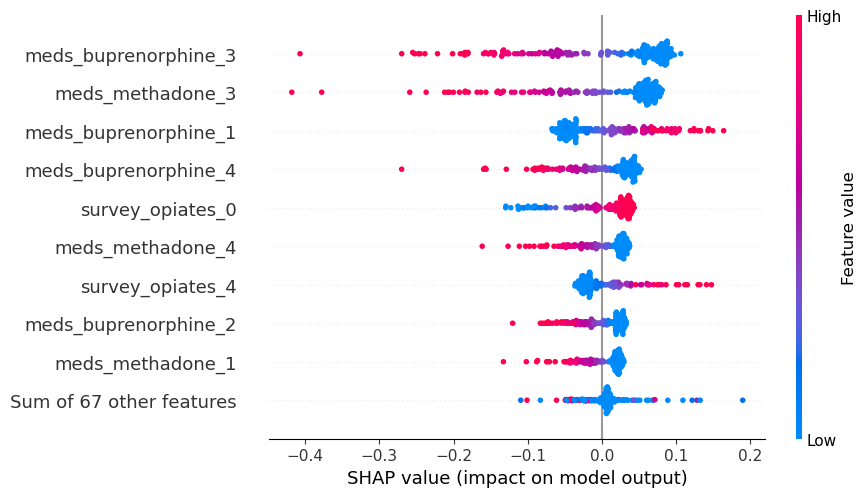

In [18]:
class_index = 0
shap.plots.beeswarm(shap_values[:,:,class_index])

In [19]:
shap.plots.force(sv_logit[0:20:,:,0])

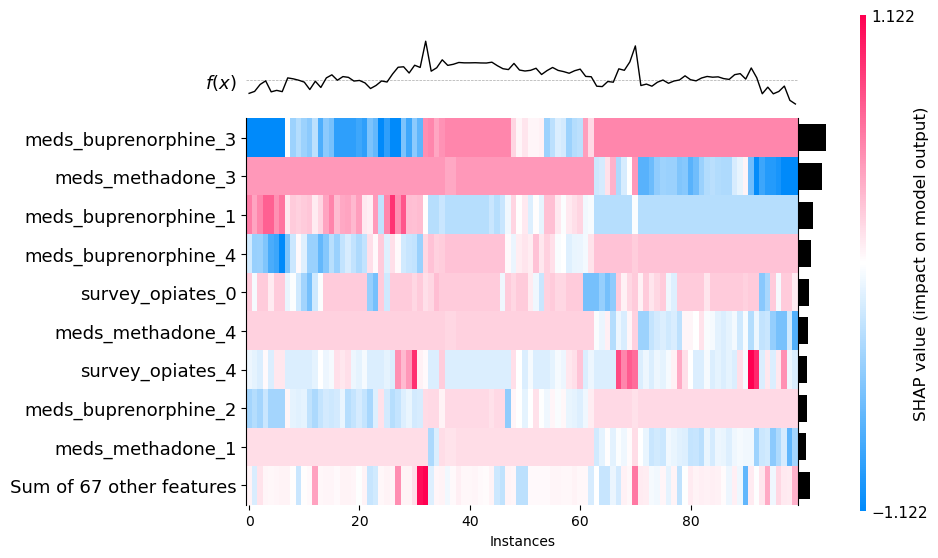

In [20]:
shap.plots.heatmap(sv_logit[:,:,class_index])